In [1]:
# The following code will solve 2 optimization problems:
# 1. The minimum flux through orfN gene (while still having biomass synthesis)
# 2. The max flux through orfN gene

In [2]:
# importing PA14 metabolic model of P. aeruginosa
import cobra
model = cobra.io.read_sbml_model("iSD1509MModel.xml")
model

Name,iSDXXXX
Memory address,10a7072e0
Number of metabolites,1642
Number of reactions,2021
Number of genes,1510
Number of groups,7
Objective expression,1.0*BIOMASS_PA14_v27M - 1.0*BIOMASS_PA14_v27M_reverse_0dc58
Compartments,"cytosol, extracellular space, periplasm"


In [3]:
default_bounds = {}
for rs in model.reactions:
    default_bounds[rs.id] = rs.bounds
    
# Making resetting model function
def reset_model(model, def_bounds, obj):
    for rs in model.reactions:
        rs.bounds = def_bounds[rs.id]
        
        rs.objective_coefficient
        
        if rs.id == obj:
            rs.objective_coefficient = 1

reset_model(model, default_bounds, 'BIOMASS_PA14_v27M')

In [4]:
# MurA gene involved in peptidoglycan biosynthesis
my_gene = model.genes.get_by_id("PA14_57810")
for rxns in my_gene.reactions:
    print(rxns)

UAGCVT: pep_c + uacgam_c --> pi_c + uaccg_c


In [5]:
# MurA catalyzed reaction
MurA_rxn = model.reactions.get_by_id('UAGCVT')
print(f'{MurA_rxn.id}\t{MurA_rxn.name}\t{MurA_rxn.reaction}')

UAGCVT	UDP-N-acetylglucosamine 1-carboxyvinyltransferase	pep_c + uacgam_c --> pi_c + uaccg_c


In [6]:
murA = model.genes.PA14_57810
reactions_murA = murA.reactions
print(murA.reactions)

frozenset({<Reaction UAGCVT at 0x14189ca30>})


In [7]:
# MurA bounds
print(f'both bounds: {MurA_rxn.bounds}') # in mmol/(gdW.hr)
print(MurA_rxn.summary())

both bounds: (0.0, 999999.0)

UAGCVT
pep_c + uacgam_c --> pi_c + uaccg_c
Bounds: 0.0, 999999.0
Flux: 0.1001



In [8]:
# Checking objective function
for reactions in model.reactions:
    if reactions.objective_coefficient == 1:
        print(f'The objective function is: {reactions.id}')

The objective function is: BIOMASS_PA14_v27M


In [9]:
solution = model.optimize()
solution

,fluxes,reduced_costs
1PPDCRc,0.0,-6.820692e-02
2AGPE140tipp,0.0,0.000000e+00
2AGPE141tipp,0.0,0.000000e+00
2AGPG140tipp,0.0,0.000000e+00
2AGPG141tipp,0.0,0.000000e+00
...,...,...
SHGO,0.0,-6.252301e-02
ACTD2_SS,0.0,5.011382e-17
23DHBSpp,0.0,0.000000e+00
ACPS1,0.0,-6.820692e-02


## Maximizing flux through reaction

In [10]:
for rxns in reactions_murA:
    #reset model
    reset_model(model, default_bounds, 'BIOMASS_PA14_v27M')
    
    # Limit growth to minimum of 0.05
    model.reactions.BIOMASS_PA14_v27M.bounds = 0.05, 1000

    # Make rxn of interest the objective function
    model.reactions.BIOMASS_PA14_v27M.objective_coefficient = 0
    rxns.objective_coefficient = 1
    
    # Optimize model to maximize flux through rxn
    max_flux = model.optimize(objective_sense='maximize')
    print(max_flux.objective_value)
   

max_flux_val = max_flux.objective_value

0.10006993837657316


In [11]:
# What is growth at max flux through MurA
# growth_rxn_maxflux = model.reactions.get_by_id('BIOMASS_PA14_v27M')
# print(growth_rxn_maxflux.summary())

## Minimizing flux through reaction

In [12]:
for rxns in reactions_murA:
    #reset model
    reset_model(model, default_bounds, 'BIOMASS_PA14_v27M')
    
    # Limit growth to minimum of 0.05
    model.reactions.BIOMASS_PA14_v27M.bounds = 0.05, 1000

    # Make rxn of interest the objective function
    model.reactions.BIOMASS_PA14_v27M.objective_coefficient = 0
    rxns.objective_coefficient = 1
    
    # Optimize model to maximize flux through rxn
    min_flux = model.optimize(objective_sense='minimize')
    print(min_flux.objective_value)
    
min_flux_val = min_flux.objective_value

0.0031450862059549988


In [13]:
# What is growth at min flux through MurA
# growth_rxn_minflux = model.reactions.get_by_id('BIOMASS_PA14_v27M')
# print(growth_rxn_minflux.summary())

In [14]:
# State newly determined bounds for reaction
min_flux_val, max_flux_val

(0.0031450862059549988, 0.10006993837657316)

## Perturbations through MurA reaction

In [15]:
import numpy as np
import pandas as pd
my_flux_vals = np.linspace(min_flux_val, max_flux_val, num=400)
my_flux_vals

array([0.00314509, 0.00338801, 0.00363093, 0.00387384, 0.00411676,
       0.00435968, 0.0046026 , 0.00484552, 0.00508844, 0.00533136,
       0.00557428, 0.0058172 , 0.00606012, 0.00630304, 0.00654596,
       0.00678888, 0.0070318 , 0.00727472, 0.00751764, 0.00776056,
       0.00800347, 0.00824639, 0.00848931, 0.00873223, 0.00897515,
       0.00921807, 0.00946099, 0.00970391, 0.00994683, 0.01018975,
       0.01043267, 0.01067559, 0.01091851, 0.01116143, 0.01140435,
       0.01164727, 0.01189019, 0.01213311, 0.01237602, 0.01261894,
       0.01286186, 0.01310478, 0.0133477 , 0.01359062, 0.01383354,
       0.01407646, 0.01431938, 0.0145623 , 0.01480522, 0.01504814,
       0.01529106, 0.01553398, 0.0157769 , 0.01601982, 0.01626274,
       0.01650565, 0.01674857, 0.01699149, 0.01723441, 0.01747733,
       0.01772025, 0.01796317, 0.01820609, 0.01844901, 0.01869193,
       0.01893485, 0.01917777, 0.01942069, 0.01966361, 0.01990653,
       0.02014945, 0.02039237, 0.02063529, 0.0208782 , 0.02112

In [16]:
# reset model
reset_model(model, default_bounds, 'BIOMASS_PA14_v27M')
print(model.reactions.BIOMASS_PA14_v27M.objective_coefficient)

MurA_rxn.bounds = 0.05160751, 0.05160751

# Optimize model to maximize flux through biomass rxn
# with specific flux through murA
solution = model.optimize(objective_sense='maximize')
print(solution.objective_value)

1.0
0.8720541785568877


In [17]:
# Model flux vector corresponding with this solution
solution.fluxes

1PPDCRc         0.0
2AGPE140tipp    0.0
2AGPE141tipp    0.0
2AGPG140tipp    0.0
2AGPG141tipp    0.0
               ... 
SHGO            0.0
ACTD2_SS        0.0
23DHBSpp        0.0
ACPS1           0.0
ACPpds          0.0
Name: fluxes, Length: 2021, dtype: float64

In [18]:
# Create empty list to input rows for each MurA flux
row_list = []
# Loop through MurA fluxes to get corresponding network fluxes
for flux in my_flux_vals:
    # Reset model
    reset_model(model, default_bounds, 'BIOMASS_PA14_v27M')
    # Set MurA flux bounds
    MurA_rxn.bounds = flux, flux
    solution = model.optimize(objective_sense='maximize')
    row_list.append(solution.fluxes)

matrix_df = pd.DataFrame(row_list)
matrix_df

,1PPDCRc,2AGPE140tipp,2AGPE141tipp,2AGPG140tipp,2AGPG141tipp,2DHGLCK,2DHGLCNkt_tpp,2HH24DDH1,2MAHMP,3_4DHBZ1t_pp,...,EX_gly_glu__L_e,BIOMASS_PA14_v27M,BIOMASS_PA14_v27M_ANA,PYOO2exNET,AHGDx,SHGO,ACTD2_SS,23DHBSpp,ACPS1,ACPpds
fluxes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.050000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fluxes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.053862,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fluxes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.057724,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fluxes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.061586,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fluxes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.065448,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fluxes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.575446,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fluxes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.579308,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fluxes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.583170,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fluxes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.587032,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
matrix_df.shape

(400, 2021)

## PCA

In [20]:
# Importing PCA class from sklearn
from sklearn.decomposition import PCA

In [21]:
# Fit PCA model to matrix
pca = PCA()
pca.fit(matrix_df)

PCA()

In [22]:
# Looking at the principal components formed
components = pca.components_
components

array([[ 4.96652210e-17,  1.90582413e-20,  6.32233862e-17, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.83411930e-17,  1.22262430e-16, -6.78507272e-17, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.55907014e-17, -1.21891429e-16,  8.45677695e-18, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-4.03133923e-04, -4.21653783e-02,  3.67083245e-02, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-3.35080601e-02,  5.66474824e-02,  1.88836373e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.72131935e-02,  2.15570798e-02,  9.09173178e-03, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]])

In [24]:
# Explained variance ratio of each principal component
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[9.14826488e-01 8.16292790e-02 3.34201703e-03 1.37782533e-04
 5.77636604e-05 5.12526042e-06 1.54431488e-06 2.36090025e-11
 3.38114504e-28 1.63039633e-29 1.41737706e-29 2.99486064e-30
 7.77400799e-31 7.21670852e-31 5.31287624e-31 3.84648491e-31
 3.03649949e-31 1.46285340e-31 1.14547551e-31 1.04979639e-31
 9.48052099e-32 6.73999746e-32 4.04133109e-32 3.17331595e-32
 2.86251655e-32 1.90962284e-32 1.16034898e-32 8.22328890e-33
 8.22328890e-33 8.22328890e-33 8.22328890e-33 8.22328890e-33
 8.22328890e-33 8.22328890e-33 8.22328890e-33 8.22328890e-33
 8.22328890e-33 8.22328890e-33 8.22328890e-33 8.22328890e-33
 8.22328890e-33 8.22328890e-33 8.22328890e-33 8.22328890e-33
 8.22328890e-33 8.22328890e-33 8.22328890e-33 8.22328890e-33
 8.22328890e-33 8.22328890e-33 8.22328890e-33 8.22328890e-33
 8.22328890e-33 8.22328890e-33 8.22328890e-33 8.22328890e-33
 8.22328890e-33 8.22328890e-33 8.22328890e-33 8.22328890e-33
 8.22328890e-33 8.22328890e-33 8.22328890e-33 8.22328890e-33
 8.22328890e-33 8.223288

In [29]:
# Keeping only first 3 principial components
pca_2 = PCA(n_components=3)
pca_2.fit(matrix_df)
print(pca_2.explained_variance_ratio_)

# Transform original matrix to principal component space
pca_matrix = pca_2.transform(matrix_df)
print(pca_matrix)
pca_matrix.shape

[0.91482649 0.08162928 0.00334202]
[[-50.60258315 -17.73219444  -0.41028725]
 [-50.38481542 -17.57775393  -0.40494479]
 [-50.16704768 -17.42331343  -0.39960232]
 ...
 [ 65.1716683  -15.78430483   8.48593104]
 [ 65.44733322 -15.90230264   9.00111004]
 [ 64.36946262 -15.28026673  17.1031658 ]]


(400, 3)

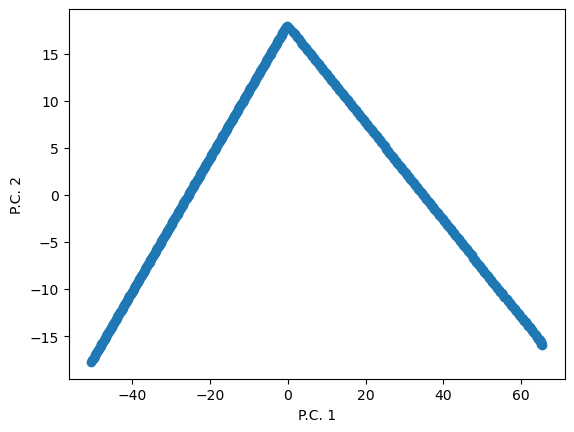

In [31]:
import matplotlib.pyplot as plt

# Graph first two principal components
x = pca_matrix[:, 0]
y = pca_matrix[:, 1]
plt.scatter(x,y)
plt.xlabel("P.C. 1")
plt.ylabel("P.C. 2")
plt.show()